# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms to player performance statistics per season. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

import matplotlib.pyplot as plt
import numpy as np
import operator
import sys

from IPython.display import display, HTML

from sklearn.linear_model          import LogisticRegression
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import LinearSVC, SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network        import MLPClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.gaussian_process      import GaussianProcessClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

## User input

Choose the year you want to use to run some validation tests (*validation_year*) and the year you want to predict (*prediction_year*), both in range 2000-2018. The years that are not selected for validation tests and prediction are used to train the model.

In [2]:
validation_year = 2017 # Enter any year from 2000 until 2018
prediction_year = 2018 # Enter any year from 2000 until 2018

print("--> Validation_year = {}".format(validation_year))
print("--> Prediction_year = {}".format(prediction_year))

first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

training_years = list(range(first_year, last_year+1))

training_years.remove(validation_year)
training_years.remove(prediction_year)

first_training_year = training_years[0]
last_training_year  = training_years[-1]
    
if (first_training_year < validation_year < last_training_year) and (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {} and {}".format(first_training_year, last_training_year, validation_year, prediction_year))
elif (first_training_year < validation_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, validation_year))
elif (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, prediction_year))
else:
    print("--> Training years  = {}-{}".format(first_training_year, last_training_year))

--> Validation_year = 2017
--> Prediction_year = 2018
--> Training years  = 2000-2016


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played in a season to be included in the analysis:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 10 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 10


## Load NBA player data:

NBA player data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions (*NBA_totals_scraper*, *NBA_advanced_scraper* and *NBA_AllStar_scraper*) in [NBAanalysissetup.py](NBAanalysissetup.py).

In [4]:
df_training, df_validation, df_prediction = \
NBAanalysissetup.loaddata_allyears(prediction_year, validation_year, training_years, includeadvancedstats)

--> Loading   training year 1999-2000 ...
--> Loading   training year 2000-2001 ...
--> Loading   training year 2001-2002 ...
--> Loading   training year 2002-2003 ...
--> Loading   training year 2003-2004 ...
--> Loading   training year 2004-2005 ...
--> Loading   training year 2005-2006 ...
--> Loading   training year 2006-2007 ...
--> Loading   training year 2007-2008 ...
--> Loading   training year 2008-2009 ...
--> Loading   training year 2009-2010 ...
--> Loading   training year 2010-2011 ...
--> Loading   training year 2011-2012 ...
--> Loading   training year 2012-2013 ...
--> Loading   training year 2013-2014 ...
--> Loading   training year 2014-2015 ...
--> Loading   training year 2015-2016 ...
--> Loading validation year 2016-2017 ...
--> Loading prediction year 2017-2018 ...


Remove players which have played less than *min_num_games* number of games:

In [5]:
print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])
print("")

df_training   = df_training  [df_training  ['G'] >= min_num_games]
df_validation = df_validation[df_validation['G'] >= min_num_games]
df_prediction = df_prediction[df_prediction['G'] >= min_num_games]

print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])

--> # of players in   training set = 7754
--> # of players in validation set = 486
--> # of players in prediction set = 526

--> # of players in   training set = 7178
--> # of players in validation set = 445
--> # of players in prediction set = 452


NaN handling:

In [6]:
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_training  [['TS%', '3PAr', 'FTr']] = df_training  [['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_validation[['TS%', '3PAr', 'FTr']] = df_validation[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_prediction[['TS%', '3PAr', 'FTr']] = df_prediction[['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])

# Remove remaining players with NaNs, if necessary:

if (df_training.shape[0] - df_training.dropna().shape[0] != 0):
    print("")
    #print("--> Players in training set with NaNs:")
    #print(df_training[df_training.isnull().any(axis=1)])
    #print("")
    df_training.dropna(inplace=True)
    print("--> # of players with NaNs in   training set =", df_training.shape[0] - df_training.dropna().shape[0])

if (df_validation.shape[0] - df_validation.dropna().shape[0] != 0):
    print("")
    #print("--> Players in validation set with NaNs:")
    #print(df_validation[df_validation.isnull().any(axis=1)])
    #print("")
    df_validation.dropna(inplace=True)
    print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])

if (df_prediction.shape[0] - df_prediction.dropna().shape[0] != 0):
    print("")
    #print("--> Players in prediction set with NaNs:")
    #print(df_prediction[df_prediction.isnull().any(axis=1)])
    #print("")
    df_prediction.dropna(inplace=True)
    print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0]) 

--> # of players with NaNs in   training set = 1002
--> # of players with NaNs in validation set = 28
--> # of players with NaNs in prediction set = 30

--> # of players with NaNs in   training set = 0
--> # of players with NaNs in validation set = 0
--> # of players with NaNs in prediction set = 0


Print overview of All-Stars:

In [7]:
for year in training_years:
    n_allstars = df_training[(df_training['YEAR'] == year) & (df_training['AS'] > 0.5)].shape[0]
    n_total    = df_training[(df_training['YEAR'] == year)].shape[0]
    print("--> Number if All-Stars in   training year {}: {} out of {} players".format(year, n_allstars, n_total))
    
n_allstars = df_validation[df_validation['AS'] > 0.5].shape[0]
n_total    = df_validation.shape[0]
print("--> Number if All-Stars in validation year {}: {} out of {} players".format(validation_year, n_allstars, n_total))

n_allstars = df_prediction[df_prediction['AS'] > 0.5].shape[0]
n_total    = df_prediction.shape[0]
print("--> Number if All-Stars in prediction year {}: {} out of {} players".format(prediction_year, n_allstars, n_total))

print("")
print("--> All-Stars {} :".format(validation_year))
#tmp = df_training[(df_training['YEAR'] == 2016) & (df_training['AS'] > 0.5)]
tmp = df_validation[df_validation['AS'] > 0.5]
display(HTML(tmp.to_html()))

--> Number if All-Stars in   training year 2000: 24 out of 403 players
--> Number if All-Stars in   training year 2001: 27 out of 399 players
--> Number if All-Stars in   training year 2002: 26 out of 409 players
--> Number if All-Stars in   training year 2003: 25 out of 401 players
--> Number if All-Stars in   training year 2004: 24 out of 402 players
--> Number if All-Stars in   training year 2005: 24 out of 426 players
--> Number if All-Stars in   training year 2006: 25 out of 430 players
--> Number if All-Stars in   training year 2007: 29 out of 427 players
--> Number if All-Stars in   training year 2008: 26 out of 418 players
--> Number if All-Stars in   training year 2009: 26 out of 415 players
--> Number if All-Stars in   training year 2010: 28 out of 417 players
--> Number if All-Stars in   training year 2011: 24 out of 424 players
--> Number if All-Stars in   training year 2012: 25 out of 435 players
--> Number if All-Stars in   training year 2013: 25 out of 436 players
--> Nu

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,AS,YEAR
15,Giannis Antetokounmpo,SF,22,MIL,80,80,2845,656,1259,0.521,49,180,0.272,607,1079,0.563,0.541,471,612,0.770,142,558,700,434,131,151,234,246,1832,26.1,0.599,0.143,0.486,5.9,22.6,14.3,26.6,2.3,4.7,13.3,28.3,7.9,4.5,12.4,0.210,4.1,3.5,7.6,6.9,1,2017
16,Carmelo Anthony,SF,32,NYK,74,74,2538,602,1389,0.433,151,421,0.359,451,968,0.466,0.488,304,365,0.833,62,376,438,213,60,34,153,198,1659,17.9,0.535,0.303,0.263,2.6,16.0,9.3,14.5,1.2,1.1,9.0,29.1,3.2,1.5,4.7,0.089,1.5,-2.2,-0.7,0.8,1,2017
65,Jimmy Butler,SF,27,CHI,76,75,2809,570,1252,0.455,91,248,0.367,479,1004,0.477,0.492,585,676,0.865,129,341,470,417,143,32,159,112,1816,25.1,0.586,0.198,0.540,4.9,13.2,9.0,24.8,2.6,0.9,9.3,26.5,10.1,3.8,13.8,0.236,5.8,1.1,6.9,6.3,1,2017
89,DeMarcus Cousins,C,26,NOP,72,72,2465,647,1432,0.452,131,363,0.361,516,1069,0.483,0.498,517,670,0.772,152,642,794,332,100,93,269,278,1942,25.8,0.562,0.253,0.468,7.0,29.2,18.2,25.8,2.0,3.4,13.5,36.5,3.9,3.8,7.6,0.149,3.9,2.6,6.6,5.3,1,2017
97,Stephen Curry,PG,28,GSW,79,79,2638,675,1443,0.468,324,789,0.411,351,654,0.537,0.580,325,362,0.898,61,292,353,524,142,17,239,183,1999,24.6,0.624,0.547,0.251,2.7,11.4,7.3,31.2,2.6,0.5,13.0,30.1,8.7,3.9,12.6,0.229,7.8,-0.4,7.3,6.2,1,2017
99,Anthony Davis,C,23,NOP,75,75,2708,770,1526,0.505,40,134,0.299,730,1392,0.524,0.518,519,647,0.802,172,712,884,157,94,167,181,168,2099,27.5,0.580,0.088,0.424,6.7,27.9,17.2,11.1,1.7,5.1,9.1,32.6,5.9,5.1,11.0,0.195,1.4,2.3,3.7,3.9,1,2017
107,DeMar DeRozan,SG,27,TOR,74,74,2620,721,1545,0.467,33,124,0.266,688,1421,0.484,0.477,545,647,0.842,70,316,386,290,78,13,180,134,2020,24.0,0.552,0.080,0.419,3.0,13.6,8.3,20.6,1.5,0.4,9.0,34.3,6.7,2.4,9.0,0.166,2.4,-1.5,0.9,1.9,1,2017
118,Kevin Durant,PF,28,GSW,62,62,2070,551,1026,0.537,117,312,0.375,434,714,0.608,0.594,336,384,0.875,39,474,513,300,66,99,138,117,1555,27.6,0.651,0.304,0.374,2.2,23.6,13.6,23.1,1.5,3.8,10.4,27.8,8.0,4.0,12.0,0.278,5.4,2.6,8.0,5.2,1,2017
144,Marc Gasol,C,32,MEM,74,74,2531,532,1160,0.459,104,268,0.388,428,892,0.480,0.503,278,332,0.837,60,404,464,338,67,99,166,171,1446,20.3,0.554,0.231,0.286,2.6,18.8,10.5,24.8,1.4,3.7,11.3,26.4,4.2,3.5,7.7,0.145,2.1,2.2,4.2,4.0,1,2017
149,Paul George,SF,26,IND,75,75,2689,622,1348,0.461,195,496,0.393,427,852,0.501,0.534,336,374,0.898,58,434,492,251,119,27,220,206,1775,20.2,0.587,0.368,0.277,2.5,17.9,10.3,16.1,2.2,0.9,12.7,28.9,3.9,3.1,7.1,0.126,3.1,-0.3,2.8,3.2,1,2017


Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [8]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_training   = df_training.  drop(['AS', 'YEAR'], axis=1)
X_validation = df_validation.drop(['AS', 'YEAR'], axis=1)
X_prediction = df_prediction.drop(['AS', 'YEAR'], axis=1)

X_list = [X_training, X_validation, X_prediction]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age',                                   # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/48 and drop G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0)
    X['MP'] = X['MP'].div(48,            axis=0)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/48'}, inplace=True)
    X.drop(['G'], axis=1, inplace=True)
    
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_training   = df_training  ['AS']
y_validation = df_validation['AS']
y_prediction = df_prediction['AS']

print("--> Training   data set      : # of players = {:4}, # of features = {}".format(X_training.shape[0], X_training.shape[1]))
print("--> Validation data set {} : # of players = {:4}, # of features = {}".format(validation_year, X_validation.shape[0], X_validation.shape[1]))
print("--> Prediction data set {} : # of players = {:4}, # of features = {}".format(prediction_year, X_prediction.shape[0], X_prediction.shape[1]))
print("")

print("--> Model features : ", list(X_training.columns))

--> Training   data set      : # of players = 7178, # of features = 22
--> Validation data set 2017 : # of players =  445, # of features = 22
--> Prediction data set 2018 : # of players =  452, # of features = 22

--> Model features :  ['GS/G', 'MP/48', '3P/48', '3PA/48', '2P/48', '2PA/48', 'FT/48', 'FTA/48', 'PF/48', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS/48', 'DWS/48', 'OBPM', 'DBPM', 'VORP']


## Select ML classifier, set hyper-parameters and instantiate model:

Choose one of the 12 classifiers in the list below (set *random_state* to specific seed value where applicable to tune hyper-parameters):

In [9]:
classifier = 1
rseed = 666

if (classifier == 1):
    C = 100  # smaller value for C results in more regularization (in case you have noisy observations)
    p = 'l2' # penalty="l1" enables Lasso regularization, penalty="l2" enables Ridge regularization. Ridge gives Shrinkage (i.e. non-sparse coefficients), Lasso gives Sparsity (i.e. prefer simpler models)
    model = LogisticRegression(C=C, penalty=p, random_state=rseed)
    modelname = 'Logistic Regression Classifier'
elif (classifier == 2):
    n_n = 10
    w = 'uniform'
    model = KNeighborsClassifier(n_neighbors=n_n, weights=w)
    modelname = 'Nearest Neighbours Classifier'
elif (classifier == 3):
    C = 1
    p = 'l2'
    model = LinearSVC(dual=False, C=C, penalty=p, random_state=rseed) #class_weight='balanced'
    #model = SVC(kernel='linear', probability=True, C=C, class_weight='balanced', random_state=rseed)
    modelname = 'Linear Support Vector Machine Classifier'
elif (classifier == 4):
    m_d = None
    m_f = 'auto'
    model = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
    modelname = 'Decision Tree Classifier'
elif (classifier == 5):
    n_e = 100
    m_d = None  # i.e. nodes are expanded until leafs are pure 
    m_f = 'auto' # The number of features to consider when looking for the best split. 'auto' => max_features=sqrt(n_features) 
    model = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
    modelname = 'Random Forest Classifier'
elif (classifier == 6):
    n_e = 100
    m_d = None
    m_f = 'auto'
    model = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
    modelname = 'Extremely Randomized Trees Classifier'
elif (classifier == 7):
    n_e = 100
    m_d = 3
    l_l = 0.1
    model = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
    modelname = 'Gradient Boost Classifier'
elif (classifier == 8):
    n_e = 100
    l_l = 0.1
    model = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
    modelname = 'AdaBoost Classifier'
elif (classifier == 9):
    model = QuadraticDiscriminantAnalysis()
    modelname = 'Quadratic Discriminant Analysis Classifier'
elif (classifier == 10):
    a = 0.0001 # L2 penalty (regularization term) parameter
    model = MLPClassifier(alpha=a, random_state=rseed)
    modelname = 'Neural Network Classifier'
elif (classifier == 11):
    model = GaussianNB()
    modelname = 'Gaussian Naive Bayes Classifier'
elif (classifier == 12): # SLOWWWWWWWWW
    model = GaussianProcessClassifier(random_state=rseed)
    modelname = 'Gaussian Process Classifier'
else:
    print("That number does not correspond to an implemented classifier - EXIT")
    
print("--> Selected classifier =", modelname)
print("--> Model parameters : ", model.get_params())

--> Selected classifier = Logistic Regression Classifier
--> Model parameters :  {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 666, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season, and calculate some model scores:

In [10]:
logo = LeaveOneGroupOut()
        
cv_groups = df_training['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_logo = logo.split(X_training, y_training, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy', 'roc_auc']

scores = cross_validate(model, X_training, y_training, cv=cv_logo, scoring=scoring_list) #, n_jobs=-1)

print("--> Cross-val years  :", ["{:5d}".format(yr) for yr in training_years])
print("")
print("--> Precision scores :", ["{:5.2f}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:5.2f}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:5.2f}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:5.2f}".format(i) for i in scores['test_accuracy' ]])
print("--> ROC-AUC   scores :", ["{:5.2f}".format(i) for i in scores['test_roc_auc'  ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("--> Recall score    : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), np.std(scores['test_recall'   ])))
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), np.std(scores['test_f1'       ])))
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), np.std(scores['test_accuracy' ])))
print("--> ROC-AUC score   : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_roc_auc'  ]), np.std(scores['test_roc_auc'  ])))

--> Cross-val years  : [' 2000', ' 2001', ' 2002', ' 2003', ' 2004', ' 2005', ' 2006', ' 2007', ' 2008', ' 2009', ' 2010', ' 2011', ' 2012', ' 2013', ' 2014', ' 2015', ' 2016']

--> Precision scores : [' 0.92', ' 0.75', ' 0.94', ' 0.81', ' 0.78', ' 0.76', ' 0.73', ' 0.76', ' 0.71', ' 0.83', ' 0.88', ' 0.79', ' 0.81', ' 0.68', ' 0.74', ' 0.95', ' 0.84']
--> Recall    scores : [' 0.50', ' 0.67', ' 0.65', ' 0.68', ' 0.75', ' 0.79', ' 0.88', ' 0.76', ' 0.65', ' 0.58', ' 0.50', ' 0.79', ' 0.68', ' 0.52', ' 0.71', ' 0.75', ' 0.81']
--> F1        scores : [' 0.65', ' 0.71', ' 0.77', ' 0.74', ' 0.77', ' 0.78', ' 0.80', ' 0.76', ' 0.68', ' 0.68', ' 0.64', ' 0.79', ' 0.74', ' 0.59', ' 0.72', ' 0.84', ' 0.82']
--> Accuracy  scores : [' 0.97', ' 0.96', ' 0.98', ' 0.97', ' 0.97', ' 0.97', ' 0.97', ' 0.97', ' 0.96', ' 0.97', ' 0.96', ' 0.98', ' 0.97', ' 0.96', ' 0.97', ' 0.98', ' 0.98']
--> ROC-AUC   scores : [' 0.99', ' 0.98', ' 0.99', ' 0.99', ' 0.98', ' 0.99', ' 1.00', ' 0.99', ' 0.99', ' 0.99', 

## Model training

Fit model to training data, use fitted model to predict validation data and calculate the corresponding confusion matrix and some model scores:

In [11]:
model.fit(X_training, y_training)     # Fit model to training data

y_model = model.predict(X_validation) # Predict validation data

y_valtrue = y_validation.tolist()

CM = confusion_matrix(y_valtrue, y_model) # defined as: rows -> true, columns -> prediction

print("--> Confusion matrix {}:".format(validation_year))
print(CM)
print("")

TN = CM[0,0] # defined as: 0 = negative, 1 = positive
FN = CM[1,0] # defined as: 0 = negative, 1 = positive
FP = CM[0,1] # defined as: 0 = negative, 1 = positive
TP = CM[1,1] # defined as: 0 = negative, 1 = positive

TOT = TP + FP + FN + TN

print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN, TN))
print("")
print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
print("")

precision = precision_score(y_validation, y_model)
recall    = recall_score   (y_validation, y_model)
f1        = f1_score       (y_validation, y_model)
accuracy  = accuracy_score (y_validation, y_model)
roc_auc   = roc_auc_score  (y_validation, y_model)
        
print("--> Precision score : {:.1%}".format(precision))
print("--> Recall score    : {:.1%}".format(recall   ))
print("--> F1 score        : {:.1%}".format(f1       ))
print("--> Accuracy score  : {:.1%}".format(accuracy ))
print("--> ROC-AUC score   : {:.1%}".format(roc_auc  ))

--> Confusion matrix 2017:
[[412   8]
 [  5  20]]

--> TP = 20, FP = 8, FN = 5, TN = 412

--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = 80.0%
--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) =  1.9%

--> Precision score : 71.4%
--> Recall score    : 80.0%
--> F1 score        : 75.5%
--> Accuracy score  : 97.1%
--> ROC-AUC score   : 89.0%


 Calculate ROC and PR curves using validation data:

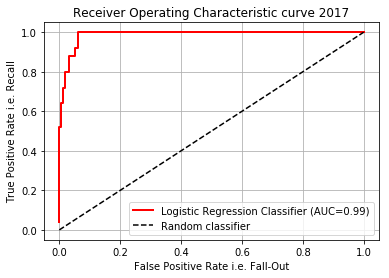

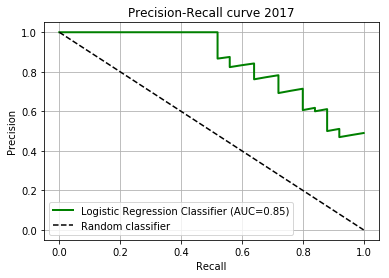

In [12]:
decisionfunctionclassifiers = [1, 3] # LogisticRegression, SVC

if (classifier in decisionfunctionclassifiers):
    y_score = model.decision_function(X_validation)
else:
    y_score = model.predict_proba(X_validation)

if (classifier in decisionfunctionclassifiers):
    fpr, tpr, thresholds = roc_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method
else:
    fpr, tpr, thresholds = roc_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='{} (AUC={:.2f})'.format(modelname, roc_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Receiver Operating Characteristic curve {}'.format(validation_year))
plt.legend(loc="lower right")
#plt.text(0.65, 0.3, r"ROC-AUC = {:.2f}".format(roc_auc), color='red')
plt.grid(True)

if (classifier in decisionfunctionclassifiers):
    precision, recall, _ = precision_recall_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method
else:
    precision, recall, _ = precision_recall_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method

pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='green', lw=2, label='{} (AUC={:.2f})'.format(modelname, pr_auc))
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve {}'.format(validation_year))
plt.legend(loc="lower left")
#plt.text(0.05, 0.3, r"PR-AUC = {:.2f}".format(pr_auc), color='green')
plt.grid(True)

Calculate the feature coefficients and importances of the fitted model, if applicable:

In [13]:
if hasattr(model, "coef_"):
    print("--> Model coefficients: ")
    print("")
    for name, coef in zip(X_training.columns, model.coef_.ravel()):
        print("----> Model coefficient {:6} = {:>6.3f}".format(name, coef))
    
if hasattr(model, "feature_importances_"):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("--> Feature importances: ")
    print("")
    
    for i in range(X_training.shape[1]):
        print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, X_training.columns[indices[i]], importances[indices[i]]))

--> Model coefficients: 

----> Model coefficient GS/G   =  7.495
----> Model coefficient MP/48  =  0.004
----> Model coefficient 3P/48  =  0.402
----> Model coefficient 3PA/48 = -0.278
----> Model coefficient 2P/48  = -0.539
----> Model coefficient 2PA/48 = -0.001
----> Model coefficient FT/48  = -0.373
----> Model coefficient FTA/48 =  0.109
----> Model coefficient PF/48  = -0.632
----> Model coefficient PER    =  0.712
----> Model coefficient ORB%   = -0.062
----> Model coefficient DRB%   = -0.079
----> Model coefficient AST%   = -0.036
----> Model coefficient STL%   = -0.963
----> Model coefficient BLK%   = -0.244
----> Model coefficient TOV%   =  0.111
----> Model coefficient USG%   =  0.409
----> Model coefficient OWS/48 =  8.597
----> Model coefficient DWS/48 = 20.883
----> Model coefficient OBPM   = -0.791
----> Model coefficient DBPM   = -0.096
----> Model coefficient VORP   =  0.859


## Model predictions

Use fitted model to predict the NBA All-Stars in *prediction_year*, and calculate the corresponding confusion matrix:

--> Confusion matrix 2018:
[[420   4]
 [ 10  18]]

--> TP = 18, FP = 4, FN = 10, TN = 420

--> Precision (TP/(TP+FP)) = 81.8% (Answers the question: How many predicted All-Stars are true All-Stars?)
--> Recall    (TP/(TP+FN)) = 64.3% (Answers the question: How many true All-Stars have been predicted?)
--> F1 score               = 72.0% (i.e. the harmonic mean of Precision and Recall)
--> Accuracy ((TP+TN)/TOT) = 96.9% (Answers the question: How many All-Stars and non-All-Stars have been correctly predicted?)


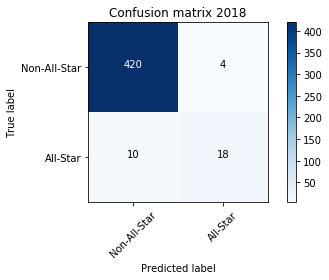

In [14]:
y_model = model.predict(X_prediction) # Use fitted model on prediction data

y_true = y_prediction.tolist()

CM = confusion_matrix(y_true, y_model) # defined as: rows -> true, columns -> prediction

print("--> Confusion matrix {}:".format(prediction_year))
print(CM)
print("")

TN = CM[0,0] # defined as: 0 = negative, 1 = positive
FN = CM[1,0] # defined as: 0 = negative, 1 = positive
FP = CM[0,1] # defined as: 0 = negative, 1 = positive
TP = CM[1,1] # defined as: 0 = negative, 1 = positive

TOT = TP + FP + FN + TN

print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN, TN))
print("")

note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
note2 = " (Answers the question: How many true All-Stars have been predicted?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: How many All-Stars and non-All-Stars have been correctly predicted?)"
    
print("--> Precision (TP/(TP+FP)) = {:5.1%}".format(TP/(TP+FP))         + note1)
print("--> Recall    (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN))         + note2)
print("--> F1 score               = {:5.1%}".format(2*TP/(2*TP+FP+FN))  + note3)
print("--> Accuracy ((TP+TN)/TOT) = {:5.1%}".format((TP+TN)/TOT)        + note4) 
    
np.set_printoptions(precision=2)
class_names = ['Non-All-Star','All-Star']

plt.figure()
NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names,
                                       title='Confusion matrix {}'.format(prediction_year))

#plt.figure()
#NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=True,
#                                       title='Normalized confusion matrix')   

Print classification report:

In [15]:
print("--> Classification report {}:".format(prediction_year))
print("")
class_names = ['Non-All-Stars (true)', 'All-Stars (true)']
print(classification_report(y_true, y_model, target_names=class_names))

--> Classification report 2018:

                      precision    recall  f1-score   support

Non-All-Stars (true)       0.98      0.99      0.98       424
    All-Stars (true)       0.82      0.64      0.72        28

         avg / total       0.97      0.97      0.97       452



Check which players are All-Stars according to the model:

In [16]:
counts = [0, 0, 0, 0]

snubbed      = []
deserved     = []
questionable = []
    
for i in range(0, len(y_model)):
    if ((y_true[i] == 0) and (y_model[i] == 0)):    # TN
        counts[0] += 1
    elif ((y_true[i] == 0) and (y_model[i] == 1)):  # FP
        counts[1] += 1
        snubbed.append(df_prediction.iat[i,0])              # 0-th column in df is player name
    elif ((y_true[i] == 1) and (y_model[i] == 0)):  # FN
        counts[2] += 1
        questionable.append(df_prediction.iat[i,0])         # 0-th column in df is player name
    else:                                           # TP
        counts[3] += 1
        deserved.append(df_prediction.iat[i,0])             # 0-th column in df is player name
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(counts[3]))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(counts[2]))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(counts[1]))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(counts[0]))
print("")
print("--> Deserved true All-Stars:     ", deserved)
print("")
print("--> Questionable true All-Stars: ", questionable)
print("")
print("--> Snubbed non-All-Stars:       ", snubbed)

--> # of     All-Stars predicted to be     All-Stars =  18 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  10 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   4 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 420 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'Kemba Walker', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'John Wall']

--> Snubbed non-All-Stars:        ['Clint Capela', 'Nikola Jokic', 'Chris Paul', 'Hassan Whiteside']


List all NBA players in *prediction_year* according to their model scores:

In [17]:
print("--> Model scores for all players in {}:".format(prediction_year))
print("")

if (classifier in decisionfunctionclassifiers):
    y_score = model.decision_function(X_prediction)
else:
    y_score = model.predict_proba(X_prediction)

player_score_dict = {}
player_AS_dict    = {}

if includeadvancedstats:
    AS_index = 49
else:
    AS_index = 29
    
for i in range(0, len(y_model)):
    if (classifier in decisionfunctionclassifiers):
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[0]
    else:
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[1]
    if df_prediction.iat[i,AS_index] > 0.5:
        status = 'All-Star'
    else:
        status = 'Non-All-Star'
    player_AS_dict[df_prediction.iat[i,0]] = status
        
sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
counter = 0
printed_line = False
for key, value in dict(sorted_player_score_dict).items():
    counter += 1
    if (classifier in decisionfunctionclassifiers):
        if (value < 0 and not printed_line):
            print("*******************************************")
            printed_line = True
    else:
        if (value < 0.5 and not printed_line):
            print("*******************************************")
            printed_line = True
    print("----> {:3}: {:24} = {:.3f} ({})".format(counter, key, value, player_AS_dict[key]))

--> Model scores for all players in 2018:

---->   1: James Harden             = 7.520 (All-Star)
---->   2: LeBron James             = 6.759 (All-Star)
---->   3: Anthony Davis            = 4.864 (All-Star)
---->   4: Kevin Durant             = 4.189 (All-Star)
---->   5: Damian Lillard           = 4.173 (All-Star)
---->   6: Giannis Antetokounmpo    = 4.072 (All-Star)
---->   7: Russell Westbrook        = 4.027 (All-Star)
---->   8: Stephen Curry            = 3.059 (All-Star)
---->   9: Kyrie Irving             = 2.996 (All-Star)
---->  10: LaMarcus Aldridge        = 2.662 (All-Star)
---->  11: Joel Embiid              = 1.682 (All-Star)
---->  12: Victor Oladipo           = 1.536 (All-Star)
---->  13: Kemba Walker             = 1.328 (All-Star)
---->  14: Andre Drummond           = 1.078 (All-Star)
---->  15: Karl-Anthony Towns       = 0.995 (All-Star)
---->  16: DeMar DeRozan            = 0.934 (All-Star)
---->  17: DeMarcus Cousins         = 0.849 (All-Star)
---->  18: Hassan Whit

----> 411: Darrun Hilliard          = -16.547 (Non-All-Star)
----> 412: Aaron Brooks             = -16.613 (Non-All-Star)
----> 413: Jason Smith              = -16.652 (Non-All-Star)
----> 414: Davon Reed               = -16.712 (Non-All-Star)
----> 415: Omer Asik                = -16.720 (Non-All-Star)
----> 416: Alex Abrines             = -16.726 (Non-All-Star)
----> 417: Julyan Stone             = -16.729 (Non-All-Star)
----> 418: Wesley Iwundu            = -16.740 (Non-All-Star)
----> 419: Caleb Swanigan           = -16.746 (Non-All-Star)
----> 420: Tarik Black              = -16.752 (Non-All-Star)
----> 421: Brandon Paul             = -16.801 (Non-All-Star)
----> 422: Jawun Evans              = -16.823 (Non-All-Star)
----> 423: Kadeem Allen             = -16.824 (Non-All-Star)
----> 424: Briante Weber            = -16.828 (Non-All-Star)
----> 425: Darrell Arthur           = -16.834 (Non-All-Star)
----> 426: Richard Jefferson        = -16.868 (Non-All-Star)
----> 427: Glenn Robinso

Print prediction features of any particular player:

In [18]:
player_name = 'LeBron James'

for i in range(0, len(X_prediction)):
    if (df_prediction.iat[i,0] == player_name):
        player_index = i
        
print("--> Classification input for", player_name, ":")
print(X_prediction.iloc[player_index])

--> Classification input for LeBron James :
GS/G       1.000000
MP/48     57.916667
3P/48      2.330935
3PA/48     6.388489
2P/48     11.343885
2PA/48    18.595683
FT/48      6.025899
FTA/48     8.270504
PF/48      2.210072
PER       28.800000
ORB%       3.600000
DRB%      22.100000
AST%      44.100000
STL%       2.000000
BLK%       2.200000
TOV%      16.100000
USG%      31.500000
OWS/48     0.174388
DWS/48     0.048345
OBPM       7.600000
DBPM       2.200000
VORP       8.300000
Name: 242, dtype: float64
